In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from duel_bandit import DuelBandit

In [2]:
class Uniform:
    def __init__(self, arms, **kwargs):
        self.arms = arms
        self.n_contexts = arms.shape[0]
        self.n_arms = arms.shape[1]
        self.d = arms.shape[2]

        self.features = []
        self.observations = []
        self.thetas = []

    def get_arms(self, context):
        # Record estimates for plotting
        if len(self.features) >= 10:
            self.thetas.append(self.get_theta_hat())

        # Selects two arms uniformly at random
        arms = np.random.choice(self.n_arms, 2, replace=False)
        return arms[0], arms[1]

    def update(self, context, arm1, arm2, observation):
        arms = self.arms[context, arm1], self.arms[context, arm2]
        self.features.append(arms[0] - arms[1])
        self.observations.append(observation)

    def get_theta_hat(self):
        # Returns the policy that finds the arm with the highest mean reward using logistic regression
        features = np.array(self.features)
        observations = np.array(self.observations)

        # Fit logistic regression
        lr = LogisticRegression(
            fit_intercept=False,
            penalty=None,
            solver="lbfgs",
            max_iter=1000,
            multi_class="ovr",
        )
        lr.fit(features, observations)
        return lr.coef_[0]

    def get_policy(self, checkpoint=None):
        theta_hat = None
        if checkpoint is None:
            theta_hat = self.thetas[-1]
        else:
            theta_hat = self.thetas[checkpoint]

        def policy(context):
            # Returns the arm with the highest mean reward
            arms = self.arms[context]
            return np.argmax(np.dot(arms, theta_hat))

        return policy

In [3]:
class UniformWithArgmax(Uniform):
    def get_arms(self, context):
        if len(self.features) < 10:
            # Call parent method if no data has been collected yet
            return super().get_arms(context)

        theta = self.get_theta_hat()
        self.thetas.append(theta)

        # Selects the arm with the highest estimated reward for the given context
        arms = self.arms[context]
        arm1 = np.argmax(arms @ theta)

        # Selects an arm uniformly at random from the remaining arms
        arm2 = np.random.choice(np.setdiff1d(range(self.n_arms), arm1))
        return arm1, arm2

In [71]:
import numpy as np

from utils.optimization import (
    fit_online_logistic_estimate,
    fit_online_logistic_estimate_bar,
)
from utils.utils import (
    sigmoid,
    dsigmoid,
    weighted_norm,
    gaussian_sample_ellipsoid,
)


class EcoLog:
    def __init__(self, param_norm_ub, arm_norm_ub, dim, failure_level):
        self.param_norm_ub = param_norm_ub
        self.arm_norm_ub = arm_norm_ub
        self.dim = dim
        self.failure_level = failure_level
        self.l2reg = 2
        self.vtilde_matrix = self.l2reg * np.eye(self.dim)
        self.vtilde_matrix_inv = (1 / self.l2reg) * np.eye(self.dim)
        self.theta = np.zeros((self.dim,))
        self.conf_radius = 0
        self.cum_loss = 0
        self.ctr = 1

    def reset(self):
        self.vtilde_matrix = self.l2reg * np.eye(self.dim)
        self.vtilde_matrix_inv = (1 / self.l2reg) * np.eye(self.dim)
        self.theta = np.zeros((self.dim,))
        self.conf_radius = 0
        self.cum_loss = 0
        self.ctr = 1

    def learn(self, arm, reward):
        # compute new estimate theta
        self.theta = np.real_if_close(
            fit_online_logistic_estimate(
                arm=arm,
                reward=reward,
                current_estimate=self.theta,
                vtilde_matrix=self.vtilde_matrix,
                vtilde_inv_matrix=self.vtilde_matrix_inv,
                constraint_set_radius=self.param_norm_ub,
                diameter=self.param_norm_ub,
                precision=1 / self.ctr,
            )
        )
        # compute theta_bar (needed for data-dependent conf. width)
        theta_bar = np.real_if_close(
            fit_online_logistic_estimate_bar(
                arm=arm,
                current_estimate=self.theta,
                vtilde_matrix=self.vtilde_matrix,
                vtilde_inv_matrix=self.vtilde_matrix_inv,
                constraint_set_radius=self.param_norm_ub,
                diameter=self.param_norm_ub,
                precision=1 / self.ctr,
            )
        )
        disc_norm = np.clip(
            weighted_norm(self.theta - theta_bar, self.vtilde_matrix), 0, np.inf
        )

        # update matrices
        sensitivity = dsigmoid(np.dot(self.theta, arm))
        self.vtilde_matrix += sensitivity * np.outer(arm, arm)
        self.vtilde_matrix_inv += (
            -sensitivity
            * np.dot(
                self.vtilde_matrix_inv,
                np.dot(np.outer(arm, arm), self.vtilde_matrix_inv),
            )
            / (1 + sensitivity * np.dot(arm, np.dot(self.vtilde_matrix_inv, arm)))
        )

        # sensitivity check
        sensitivity_bar = dsigmoid(np.dot(theta_bar, arm))
        if sensitivity_bar / sensitivity > 2:
            msg = f"\033[95m Oops. ECOLog has a problem: the data-dependent condition was not met. This is rare; try increasing the regularization (self.l2reg) \033[95m"
            raise ValueError(msg)

        # update sum of losses
        coeff_theta = sigmoid(np.dot(self.theta, arm))
        loss_theta = -reward * np.log(coeff_theta) - (1 - reward) * np.log(
            1 - coeff_theta
        )
        coeff_bar = sigmoid(np.dot(theta_bar, arm))
        loss_theta_bar = -reward * np.log(coeff_bar) - (1 - reward) * np.log(
            1 - coeff_bar
        )
        self.cum_loss += (
            2 * (1 + self.param_norm_ub) * (loss_theta_bar - loss_theta)
            - 0.5 * disc_norm
        )

    def pull(self, arm_set):
        # bonus-based version (strictly equivalent to param-based for this algo) of OL2M
        max = -np.inf
        argmax = None
        for i, arm in enumerate(arm_set):
            opreward = self.compute_optimistic_reward(arm)
            if opreward > max:
                max = opreward
                argmax = i

        # update ctr
        self.ctr += 1
        return argmax

    def update_ucb_bonus(self):
        """
        Updates the ucb bonus function (a more precise version of Thm3 in ECOLog paper, refined for the no-warm up alg)
        """
        gamma = np.sqrt(self.l2reg) / 2 + 2 * np.log(
            2 * np.sqrt(1 + self.ctr / (4 * self.l2reg)) / self.failure_level
        ) / np.sqrt(self.l2reg)
        res_square = (
            2 * self.l2reg * self.param_norm_ub**2
            + (1 + self.param_norm_ub) ** 2 * gamma
            + self.cum_loss
        )
        self.conf_radius = np.sqrt(res_square)

    def compute_optimistic_reward(self, arm):
        """
        Returns prediction + exploration_bonus for arm.
        """
        norm = weighted_norm(arm, self.vtilde_matrix_inv)
        pred_reward = sigmoid(np.sum(self.theta * arm))
        bonus = self.conf_radius * norm
        return pred_reward + bonus

    def compute_pessimistic_reward(self, arm):
        """
        Returns prediction + exploration_bonus for arm.
        """
        norm = weighted_norm(arm, self.vtilde_matrix_inv)
        pred_reward = sigmoid(np.sum(self.theta * arm))
        bonus = self.conf_radius * norm
        return pred_reward - bonus

In [105]:
class ECOLOG(Uniform):
    def __init__(
        self,
        arms,
        param_norm_ub=None,
        failure_level=0.05,
        **kwargs,
    ):
        super().__init__(arms, **kwargs)
        assert (
            param_norm_ub is not None
        ), "param_norm_ub must be specified for Confidence algorithm"
        self.param_norm_ub = param_norm_ub
        self.failure_level = failure_level
        # Assert all arms have norm bounded by param_norm_ub
        self.arm_norm_ub = 1
        assert np.all(
            np.linalg.norm(self.arms, axis=2) <= self.param_norm_ub
        ), "All arms must have norm bounded by param_norm_ub"
        self.ecolog = EcoLog(
            param_norm_ub=self.param_norm_ub,
            arm_norm_ub=self.arm_norm_ub,
            dim=self.d,
            failure_level=self.failure_level,
        )
        self.armpairs = self.create_armpairs()

    def create_armpairs(self):
        # We need to create a set of arms based on pairing "different" arms together
        n_pairs = self.n_arms**2 - self.n_arms
        armpairs = np.zeros((self.n_contexts, n_pairs, self.d))
        for i in range(self.n_contexts):
            for j in range(self.n_arms):
                sub_one = 0
                for k in range(self.n_arms):
                    if j == k:
                        sub_one = 1
                        continue
                    armpairs[i, j * (self.n_arms - 1) + k - sub_one] = (
                        self.arms[i, j] - self.arms[i, k]
                    )
        return armpairs

    def get_arms(self, context):
        # Record the theta
        self.thetas.append(self.ecolog.theta)
        # Choose arms according to the ECOLog algorithm
        active_arms = self.armpairs[context]
        arm_pair_index = self.ecolog.pull(active_arms)
        # We need to convert the arm_pair_index to the index of the original arms
        arm1 = arm_pair_index // (self.n_arms - 1)
        arm2 = arm_pair_index % (self.n_arms - 1)
        return arm1, arm2

    def update(self, context, arm1, arm2, reward):
        # Update the ECOLog algorithm
        self.ecolog.learn(
            arm=self.armpairs[context, arm1 * (self.n_arms - 1) + arm2 - 1],
            reward=reward,
        )

    def get_policy(self, checkpoint=None):
        theta_hat = None
        if checkpoint is None:
            theta_hat = self.thetas[-1]
        else:
            theta_hat = self.thetas[checkpoint]

        def policy(context):
            # Returns the arm with the highest mean reward
            arms = self.arms[context]
            return np.argmax(np.dot(arms, theta_hat))

        return policy

In [106]:
class UCB_LCB(ECOLOG):
    def get_arms(self, context):
        # Record the theta
        self.thetas.append(self.ecolog.theta)
        # Choose arms according to our strategy
        max_ucb = -np.inf
        max_ucb_arm = None
        for i, arm in enumerate(self.arms[context]):
            ucb = self.ecolog.compute_optimistic_reward(arm)
            if ucb > max_ucb:
                max_ucb = ucb
                max_ucb_arm = i
        lcb = self.ecolog.compute_optimistic_reward(self.arms[context][max_ucb_arm])
        arm2 = None
        arm2_delta = -np.inf
        for i, arm in enumerate(self.arms[context]):
            if i == max_ucb_arm:
                continue
            ucb_arm = self.ecolog.compute_optimistic_reward(arm)
            if ucb_arm < lcb:
                continue
            delta = np.abs(
                np.dot(self.ecolog.theta, arm - self.arms[context][max_ucb_arm])
            )
            if delta > arm2_delta:
                arm2_delta = delta
                arm2 = i
        if arm2 is None:
            # pick some arm at random that is not the max_ucb_arm
            arm2 = np.random.choice(
                [i for i in range(len(self.arms[context])) if i != max_ucb_arm]
            )
        return max_ucb_arm, arm2

In [107]:
class ARGMAX_UCB(ECOLOG):
    def get_arms(self, context):
        # Record the theta
        self.thetas.append(self.ecolog.theta)
        # Choose arms according to our strategy
        max_value = -np.inf
        max_value_arm = None
        for i, arm in enumerate(self.arms[context]):
            value = np.dot(self.ecolog.theta, arm)
            if value > max_value:
                max_value = value
                max_value_arm = i
        max_ucb = -np.inf
        max_ucb_arm = None
        for i, arm in enumerate(self.arms[context]):
            if i == max_value_arm:
                continue
            ucb_arm = self.ecolog.compute_optimistic_reward(arm)
            if ucb_arm > max_ucb:
                max_ucb = ucb_arm
                max_ucb_arm = i
        return max_value_arm, max_ucb_arm

In [117]:
class MAX_UNCERTAINTY(ECOLOG):
    def get_arms(self, context):
        # Record the theta
        self.thetas.append(self.ecolog.theta)
        active_arms = self.armpairs[context]
        max_uncertainty = -np.inf
        max_arm_pair_index = None
        for i, arm in enumerate(active_arms):
            uncertainty = weighted_norm(arm, self.ecolog.vtilde_matrix_inv)
            if uncertainty > max_uncertainty:
                max_uncertainty = uncertainty
                max_arm_pair_index = i

        arm1 = max_arm_pair_index // (self.n_arms - 1)
        arm2 = max_arm_pair_index % (self.n_arms - 1)
        return arm1, arm2

In [118]:
def interact(
    env,
    ALG,
    n_steps=1000,
):
    param_norm_ub = env.true_param_norm_up()
    alg = ALG(
        env.arms,
        param_norm_ub=param_norm_ub,
    )
    context = env.context
    for i in range(n_steps):
        arm1, arm2 = alg.get_arms(context)
        previous_context = context
        result, context = env.duel(arm1, arm2)
        alg.update(previous_context, arm1, arm2, result)
        if i % 100 == 0:
            print(f"Step {i}: {ALG.__name__}")
    return alg

In [126]:
n_arms = 20
n_contexts = 20
runs = 7
d = 10
n_steps = 1500
ALGS = [
    UCB_LCB,
    ECOLOG,
    ARGMAX_UCB,
    MAX_UNCERTAINTY,
    Uniform,
    UniformWithArgmax,
]
algs = {ALG.__name__: [] for ALG in ALGS}
envs = []
for run in range(runs):
    env = DuelBandit(n_arms=n_arms, n_contexts=n_contexts, d=d)
    env.reset(fit_into_unit_ball=True)
    envs.append(env)
    for ALG in ALGS:
        print(f"Running {ALG.__name__} run {run}")
        alg = interact(env, ALG, n_steps=n_steps)
        algs[ALG.__name__].append(alg)

Running UCB_LCB run 0
Step 0: UCB_LCB
Step 100: UCB_LCB
Step 200: UCB_LCB
Step 300: UCB_LCB
Step 400: UCB_LCB
Step 500: UCB_LCB
Step 600: UCB_LCB
Step 700: UCB_LCB
Step 800: UCB_LCB
Step 900: UCB_LCB
Step 1000: UCB_LCB
Step 1100: UCB_LCB
Step 1200: UCB_LCB
Step 1300: UCB_LCB
Step 1400: UCB_LCB
Running ECOLOG run 0
Step 0: ECOLOG
Step 100: ECOLOG
Step 200: ECOLOG
Step 300: ECOLOG
Step 400: ECOLOG
Step 500: ECOLOG
Step 600: ECOLOG
Step 700: ECOLOG
Step 800: ECOLOG
Step 900: ECOLOG
Step 1000: ECOLOG
Step 1100: ECOLOG
Step 1200: ECOLOG
Step 1300: ECOLOG
Step 1400: ECOLOG
Running ARGMAX_UCB run 0
Step 0: ARGMAX_UCB
Step 100: ARGMAX_UCB
Step 200: ARGMAX_UCB
Step 300: ARGMAX_UCB
Step 400: ARGMAX_UCB
Step 500: ARGMAX_UCB
Step 600: ARGMAX_UCB
Step 700: ARGMAX_UCB
Step 800: ARGMAX_UCB
Step 900: ARGMAX_UCB
Step 1000: ARGMAX_UCB
Step 1100: ARGMAX_UCB
Step 1200: ARGMAX_UCB
Step 1300: ARGMAX_UCB
Step 1400: ARGMAX_UCB
Running MAX_UNCERTAINTY run 0
Step 0: MAX_UNCERTAINTY
Step 100: MAX_UNCERTAINTY
Ste

In [253]:
import numpy as np


class NeedleDuelBandit(DuelBandit):
    def reset(self, fit_into_unit_ball=False):
        # set arms features to zero in the beginning
        self.arms = np.random.normal(size=(self.n_contexts, self.n_arms, self.d))
        self.arms[:, :, 0] = self.arms[:, :, 0] / 100
        self.arms[0, 0, 0] = 1
        if fit_into_unit_ball:
            # cut the arms to fit into the unit ball
            for c in range(self.n_contexts):
                for a in range(self.n_arms):
                    if np.linalg.norm(self.arms[c, a]) > 1:
                        self.arms[c, a] /= np.linalg.norm(self.arms[c, a])

        # set the hidden variable to (1, 0, ..., 0)
        self.theta = np.zeros((self.d))
        self.theta[0] = 5

        # set the current context
        self.context = np.random.randint(0, self.n_contexts)

        return self.context

In [261]:
n_arms = 20
n_contexts = 40
runs = 7
d = 10
n_steps = 1500
ALGS = [
    UCB_LCB,
    ECOLOG,
    ARGMAX_UCB,
    MAX_UNCERTAINTY,
    Uniform,
    UniformWithArgmax,
]
algs = {ALG.__name__: [] for ALG in ALGS}
envs = []
for run in range(runs):
    env = NeedleDuelBandit(n_arms=n_arms, n_contexts=n_contexts, d=d)
    env.reset(fit_into_unit_ball=True)
    envs.append(env)
    for ALG in ALGS:
        print(f"Running {ALG.__name__} run {run}")
        alg = interact(env, ALG, n_steps=n_steps)
        algs[ALG.__name__].append(alg)

Running UCB_LCB run 0
Step 0: UCB_LCB
Step 100: UCB_LCB
Step 200: UCB_LCB
Step 300: UCB_LCB
Step 400: UCB_LCB
Step 500: UCB_LCB
Step 600: UCB_LCB
Step 700: UCB_LCB
Step 800: UCB_LCB
Step 900: UCB_LCB
Step 1000: UCB_LCB
Step 1100: UCB_LCB
Step 1200: UCB_LCB
Step 1300: UCB_LCB
Step 1400: UCB_LCB
Running ECOLOG run 0
Step 0: ECOLOG
Step 100: ECOLOG
Step 200: ECOLOG
Step 300: ECOLOG
Step 400: ECOLOG
Step 500: ECOLOG
Step 600: ECOLOG
Step 700: ECOLOG
Step 800: ECOLOG
Step 900: ECOLOG
Step 1000: ECOLOG
Step 1100: ECOLOG
Step 1200: ECOLOG
Step 1300: ECOLOG
Step 1400: ECOLOG
Running ARGMAX_UCB run 0
Step 0: ARGMAX_UCB
Step 100: ARGMAX_UCB
Step 200: ARGMAX_UCB
Step 300: ARGMAX_UCB
Step 400: ARGMAX_UCB
Step 500: ARGMAX_UCB
Step 600: ARGMAX_UCB
Step 700: ARGMAX_UCB
Step 800: ARGMAX_UCB
Step 900: ARGMAX_UCB
Step 1000: ARGMAX_UCB
Step 1100: ARGMAX_UCB
Step 1200: ARGMAX_UCB
Step 1300: ARGMAX_UCB
Step 1400: ARGMAX_UCB
Running MAX_UNCERTAINTY run 0
Step 0: MAX_UNCERTAINTY
Step 100: MAX_UNCERTAINTY
Ste

## Simple regret

In [257]:
def compute_simple_regret(algs, env, checkpoints):
    regrets = {alg_name: [] for alg_name in algs.keys()}
    for checkpoint in checkpoints:
        for alg_name, alg in algs.items():
            policy = alg.get_policy(checkpoint)
            regret = 0
            for context in range(env.n_contexts):
                best_arm = env.best_arm(context)
                chosen_arm = policy(context)
                regret += np.dot(
                    (env.arms[context, best_arm] - env.arms[context, chosen_arm]),
                    env.theta,
                )
                assert regret >= 0
            regrets[alg_name].append(regret / env.n_contexts)
    return regrets

In [258]:
def plot_simple_regrets(checkpoints, simple_regrets_across_runs):
    plt.figure(figsize=(16, 8))
    for alg_name, regret_list in simple_regrets_across_runs.items():
        rs = np.array(regret_list)  # shape: (n_runs, n_checkpoints)
        means = np.mean(rs, axis=0)
        stds = np.std(rs, axis=0)
        plt.plot(checkpoints, means, label=alg_name)
        plt.fill_between(checkpoints, means - stds, means + stds, alpha=0.2)
    plt.xlabel("Checkpoints")
    plt.ylabel("Simple Regrets")
    plt.title("Simple Regrets vs Checkpoints")
    plt.legend()
    plt.show()

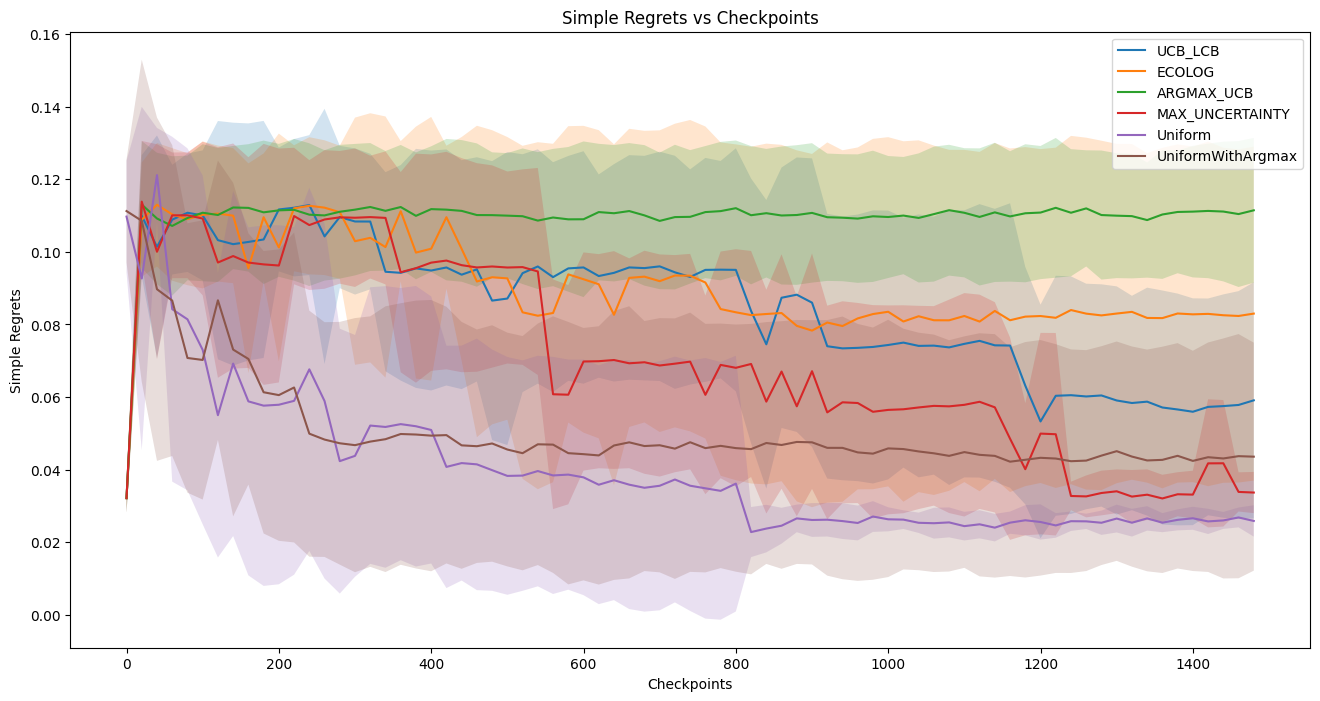

In [259]:
ALGS = [
    UCB_LCB,
    ECOLOG,
    ARGMAX_UCB,
    MAX_UNCERTAINTY,
    Uniform,
    UniformWithArgmax,
]
checkpoints = range(0, n_steps, 20)
simple_regrets_across_runs = {ALG.__name__: [] for ALG in ALGS}
for i in range(runs):
    algs_i = {ALG.__name__: algs[ALG.__name__][i] for ALG in ALGS}
    simple_regrets = compute_simple_regret(algs_i, envs[i], checkpoints)
    for ALG in ALGS:
        simple_regrets_across_runs[ALG.__name__].append(simple_regrets[ALG.__name__])
    # So at the end, simple_regrets_across_runs is a dictionary of lists of lists
    # where the outer list is indexed by algorithm name, the middle list is indexed
    # by runs, and the inner list is indexed by checkpoints.

plot_simple_regrets(checkpoints, simple_regrets_across_runs)

In [246]:
class NeedleDuelBandit(DuelBandit):
    def reset(self, fit_into_unit_ball=False):
        # set arms features to zero in the beginning
        self.arms = np.random.normal(size=(self.n_contexts, self.n_arms, self.d))
        self.arms[:, :, 0] = self.arms[:, :, 0] / 100
        self.arms[0, 0, 0] = 1
        if fit_into_unit_ball:
            # cut the arms to fit into the unit ball
            for c in range(self.n_contexts):
                for a in range(self.n_arms):
                    if np.linalg.norm(self.arms[c, a]) > 1:
                        self.arms[c, a] /= np.linalg.norm(self.arms[c, a])

        # set the hidden variable to (1, 0, ..., 0)
        self.theta = np.zeros((self.d))
        self.theta[0] = 5

        # set the current context
        self.context = np.random.randint(0, self.n_contexts)

        return self.context

In [ ]:
class AntiUCBDuelBandit(DuelBandit):
    def reset(self, fit_into_unit_ball=False):
        # set arms features to zero in the beginning
        self.arms = np.random.normal(size=(self.n_contexts, self.n_arms, self.d))
        self.arms[:, :, 0] = self.arms[:, :, 0] / 100
        self.arms[0, 0, 0] = 1
        if fit_into_unit_ball:
            # cut the arms to fit into the unit ball
            for c in range(self.n_contexts):
                for a in range(self.n_arms):
                    if np.linalg.norm(self.arms[c, a]) > 1:
                        self.arms[c, a] /= np.linalg.norm(self.arms[c, a])

        # set the hidden variable to (1, 0, ..., 0)
        self.theta = np.zeros((self.d))
        self.theta[0] = 5

        # set the current context
        self.context = np.random.randint(0, self.n_contexts)

        return self.context

In [252]:
needle = NeedleDuelBandit(20, 20, 10)
needle.reset(fit_into_unit_ball=True)
one_wins = 0
for i in range(19):
    needle.context = 5
    actual_feature = needle.arms[needle.context, 0] - needle.arms[needle.context, i + 1]
    print("llll")
    print(actual_feature, needle.theta)
    print(np.dot(actual_feature, needle.theta))
    pp = np.exp(np.dot(actual_feature, needle.theta))
    p = pp / (1 + pp)
    obs, context = needle.duel(0, i + 1)
    one_wins += obs
    print(p)
    obs = np.random.choice([0, 1], p=[1 - p, p])
    print(obs)
    print("=-----")
print(one_wins / 19)

llll
[-0.00154758 -0.01961207 -1.10192479 -0.12692561 -0.29806059 -0.51068234
 -0.07879108 -0.52743141  0.14220802 -0.66312024] [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.007737924202405051
0.49806552860167125
0
=-----
llll
[-0.00822951  0.58995324 -0.56978665 -0.02689697  0.89423215 -0.0022572
  0.0638816  -0.51327536  0.45224512  0.02447853] [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.0411475382528741
0.48971456660183293
0
=-----
llll
[-0.00604436  0.17943051 -1.23584586 -0.26499909  0.27730608  0.37861854
 -0.09219442  0.30838018  0.74277527 -0.45598583] [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.030221798248632126
0.4924451254539409
0
=-----
llll
[-0.00624756  0.68470648 -0.35607141  0.26800144  0.82385054 -0.52998418
 -0.1548061  -0.24234762  0.18554364 -0.50406846] [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.031237776260386842
0.4921911909100341
1
=-----
llll
[-0.00905231  0.16606337 -0.93685555  0.44359544  0.30350149  0.15223
 -0.65257143 -0.25106798 -0.12270016  0.27526913] [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.0

In [224]:
for i in range(20):
    for j in range(20):
        print(f"action {j}:", np.linalg.norm(needle.arms[i][j]))

action 0: 0.9999999999999999
action 1: 1.0
action 2: 0.9999999999999999
action 3: 1.0
action 4: 0.9999999999999999
action 5: 1.0
action 6: 1.0
action 7: 1.0
action 8: 1.0
action 9: 1.0
action 10: 1.0
action 11: 1.0
action 12: 0.9999999999999999
action 13: 1.0
action 14: 1.0
action 15: 1.0
action 16: 1.0
action 17: 0.9999999999999999
action 18: 0.9999999999999999
action 19: 1.0
action 0: 1.0
action 1: 1.0
action 2: 0.9999999999999999
action 3: 1.0
action 4: 0.9999999999999999
action 5: 0.9999999999999998
action 6: 0.9999999999999999
action 7: 1.0
action 8: 0.9999999999999999
action 9: 0.9999999999999999
action 10: 1.0
action 11: 1.0
action 12: 1.0
action 13: 0.9999999999999999
action 14: 1.0
action 15: 1.0000000000000002
action 16: 1.0
action 17: 0.9999999999999999
action 18: 1.0
action 19: 1.0
action 0: 0.9999999999999999
action 1: 1.0
action 2: 1.0
action 3: 0.9999999999999999
action 4: 1.0
action 5: 0.9999999999999998
action 6: 1.0
action 7: 1.0
action 8: 0.9999999999999998
action 9:

In [230]:
needle.arms[0, 0]

array([ 0.34207873,  0.29706702,  0.21050978, -0.67890417, -0.0607661 ,
       -0.0349754 ,  0.06143865, -0.16272195, -0.10901026,  0.49239812])